In [2]:
# Install necessary packages
!pip install numpy pandas matplotlib scikit-learn tensorflow pyswarm
!pip install --upgrade yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=649a4dc0d3c06d2ef7da5286895c5660219ec7fca1f0b092b5730d072bad2837
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.3 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=275728 sha256=16e533ab8d5bb7f91c408266394cbba84b50692fa8240d78957f83aa571fd30a
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
import torch
torch.manual_seed(42)

# 1. Data Acquisition
def fetch_data(ticker='^NSEI', period='10y'):
    """
    Fetch historical stock data using yfinance.

    Parameters:
        ticker (str): Stock ticker symbol. '^NSEI' represents Nifty50 index.
        period (str): Data period to download.

    Returns:
        DataFrame: Pandas DataFrame with Date and Close columns.
    """
    df = yf.download(ticker, period=period)
    print(df)
    if df.empty:
        raise ValueError(f"No data fetched for ticker {ticker}. Please check the ticker symbol.")
    df = df[['Close']]
    print(df)
    df.reset_index(inplace=True)
    df = df[['Date', 'Close']]
    print(df)
    return df

# 2. Data Cleaning
def clean_data(df):
    """
    Handle missing values and remove outliers.

    Parameters:
        df (DataFrame): Original stock data.

    Returns:
        DataFrame: Cleaned stock data.
    """
    # Handle missing values by forward fill
    df['Close'].fillna(method='ffill', inplace=True)

    # Remove outliers using z-score
    df = df[(np.abs(stats.zscore(df['Close'])) < 3)]
    df.reset_index(drop=True, inplace=True)
    return df

# 3. Feature Engineering
def feature_engineering(df):
    """
    Generate additional features such as moving averages and RSI.

    Parameters:
        df (DataFrame): Cleaned stock data.

    Returns:
        DataFrame: Stock data with additional features.
    """
    # Moving Averages
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Fill NaN values resulting from rolling calculations
    df.fillna(method='bfill', inplace=True)
    return df

# 4. Data Normalization
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    """
    Normalize the feature data using Min-Max scaling.

    Parameters:
        df (DataFrame): Stock data with features.

    Returns:
        ndarray: Normalized feature data.
        MinMaxScaler: Fitted scaler object.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', 'MA_10', 'MA_50', 'RSI']])
    return scaled_data, scaler

# 5. Create Sequences for LSTM
def create_sequences(data, sequence_length=60):
    """
    Create input sequences and corresponding targets for LSTM.

    Parameters:
        data (ndarray): Normalized feature data.
        sequence_length (int): Number of time steps in each input sequence.

    Returns:
        ndarray: Input sequences.
        ndarray: Target values.
    """
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # Predicting 'Close' price
    X, y = np.array(X), np.array(y)
    return X, y

# Fetch and preprocess data
try:
    df = fetch_data()
    df = clean_data(df)
    df = feature_engineering(df)
    scaled_data, scaler = normalize_data(df)
    print("Data acquisition and preprocessing completed successfully.")
except Exception as e:
    print(f"Error during data acquisition and preprocessing: {e}")
    exit()

# Create sequences
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets (80%, 20%)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


[*********************100%***********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2014-10-01   7960.500000   7977.500000   7936.700195   7945.549805   
2014-10-07   7897.399902   7943.049805   7842.700195   7852.399902   
2014-10-08   7828.750000   7869.899902   7815.750000   7842.700195   
2014-10-09   7886.500000   7972.350098   7886.500000   7960.549805   
2014-10-10   7911.000000   7924.049805   7848.450195   7859.950195   
...                  ...           ...           ...           ...   
2024-09-25  25899.449219  26032.800781  25871.349609  26004.150391   
2024-09-26  26005.400391  26250.900391  25998.400391  26216.050781   
2024-09-27  26248.250000  26277.349609  26151.400391  26178.949219   
2024-09-30  26061.300781  26134.699219  25794.099609  25810.849609   
2024-10-01  25788.449219  25907.599609  25739.199219  25796.900391   

               Adj Close  Volume  
Date                              
2014-10-01   7945.5


/tmp/ipykernel_30/2619997970.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_30/2619997970.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_30/2619997970.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fil

In [7]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=50, num_layers=2, dropout=0.2):
        """
        Initialize the LSTM model.

        Parameters:
            input_size (int): Number of input features.
            hidden_size (int): Number of LSTM units.
            num_layers (int): Number of stacked LSTM layers.
            dropout (float): Dropout rate for regularization.
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass of the LSTM model.

        Parameters:
            x (tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            tensor: Output tensor of shape (batch_size, 1).
        """
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, sequence_length, hidden_size)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through the output layer
        out = self.fc(out)  # (batch_size, 1)
        return out

def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, learning_rate=0.001, device='cpu'):
    """
    Train the LSTM model.

    Parameters:
        model (nn.Module): The LSTM model to train.
        X_train (tensor): Training input data.
        y_train (tensor): Training target data.
        X_test (tensor): Testing input data.
        y_test (tensor): Testing target data.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size.
        learning_rate (float): Learning rate for the optimizer.
        device (str): Device to train on ('cpu' or 'cuda').

    Returns:
        model (nn.Module): Trained model.
        train_losses (list): List of training losses per epoch.
        test_losses (list): List of testing losses per epoch.
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))

        epoch_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / (X_train.size(0) / batch_size)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            outputs = model(X_test.to(device))
            test_loss = criterion(outputs, y_test.to(device)).item()
            test_losses.append(test_loss)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}")

    return model, train_losses, test_losses


In [8]:
import random

class Particle:
    def __init__(self, bounds):
        """
        Initialize a particle with random position and velocity.

        Parameters:
            bounds (list of tuples): Each tuple contains (min, max) for a hyperparameter.
        """
        self.position = []
        self.velocity = []
        for (min_val, max_val) in bounds:
            self.position.append(random.uniform(min_val, max_val))
            # Initialize velocity with a fraction of the range
            self.velocity.append(random.uniform(-0.1*(max_val - min_val), 0.1*(max_val - min_val)))
        self.best_position = list(self.position)
        self.best_score = float('inf')
        self.score = float('inf')

class PSO:
    def __init__(self, func, bounds, num_particles, max_iter, w=0.5, c1=1, c2=2):
        """
        Initialize the PSO algorithm.

        Parameters:
            func (callable): The fitness function to minimize.
            bounds (list of tuples): Bounds for each dimension.
            num_particles (int): Number of particles in the swarm.
            max_iter (int): Maximum number of iterations.
            w (float): Inertia weight.
            c1 (float): Cognitive coefficient.
            c2 (float): Social coefficient.
        """
        self.func = func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.swarm = [Particle(bounds) for _ in range(num_particles)]
        self.global_best_position = []
        self.global_best_score = float('inf')

    def optimize(self):
        """
        Execute the PSO optimization process.

        Returns:
            list: Best hyperparameters found.
            float: Best score achieved.
        """
        for iteration in range(self.max_iter):
            print(f"\n--- Iteration {iteration+1}/{self.max_iter} ---")
            for idx, particle in enumerate(self.swarm):
                # Evaluate fitness
                particle.score = self.func(particle.position)

                # Update personal best
                if particle.score < particle.best_score:
                    particle.best_score = particle.score
                    particle.best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New personal best score {particle.best_score:.6f}")

                # Update global best
                if particle.score < self.global_best_score:
                    self.global_best_score = particle.score
                    self.global_best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New global best score {self.global_best_score:.6f}")

            # Update velocity and position for each particle
            for particle in self.swarm:
                for i in range(len(particle.position)):
                    r1 = random.random()
                    r2 = random.random()

                    # Update velocity
                    cognitive = self.c1 * r1 * (particle.best_position[i] - particle.position[i])
                    social = self.c2 * r2 * (self.global_best_position[i] - particle.position[i])
                    particle.velocity[i] = self.w * particle.velocity[i] + cognitive + social

                    # Update position
                    particle.position[i] += particle.velocity[i]

                    # Clamp to bounds
                    min_val, max_val = self.bounds[i]
                    if particle.position[i] < min_val:
                        particle.position[i] = min_val
                    elif particle.position[i] > max_val:
                        particle.position[i] = max_val

            print(f"End of Iteration {iteration+1}: Global Best Score = {self.global_best_score:.6f}")
        return self.global_best_position, self.global_best_score


In [9]:
def fitness_function(hyperparams):
    """
    Define the fitness function for PSO, which evaluates the test loss of an ensemble-LSTM model.

    Parameters:
        hyperparams (list): List of hyperparameters [num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs].

    Returns:
        float: Test loss (MSE).
    """
    num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs = hyperparams

    # Ensure hyperparameters are within reasonable bounds
    num_ensembles = int(max(min(num_ensembles, 10), 1))        # 1 to 10
    learning_rate = max(min(learning_rate, 0.01), 0.0001)      # 0.0001 to 0.01
    lstm_units = int(max(min(lstm_units, 200), 10))            # 10 to 200
    dropout_rate = max(min(dropout_rate, 0.5), 0.0)           # 0.0 to 0.5
    batch_size = int(max(min(batch_size, 512), 16))           # 16 to 512
    epochs = int(max(min(epochs, 100), 10))                   # 10 to 100

    print(f"\nEvaluating Hyperparameters: Ensembles={num_ensembles}, LR={learning_rate}, Units={lstm_units}, Dropout={dropout_rate}, Batch Size={batch_size}, Epochs={epochs}")

    # Initialize list to store individual model losses
    ensemble_losses = []

    try:
        # Train each model in the ensemble
        for i in range(num_ensembles):
            print(f"  Training ensemble model {i+1}/{num_ensembles}")
            model = LSTMModel(input_size=4, hidden_size=lstm_units, num_layers=2, dropout=dropout_rate)
            model, train_losses, test_losses = train_model(
                model, 
                X_train_tensor, 
                y_train_tensor, 
                X_test_tensor, 
                y_test_tensor, 
                epochs=epochs, 
                batch_size=batch_size, 
                learning_rate=learning_rate, 
                device=device
            )
            # Evaluate on test set
            model.eval()
            with torch.no_grad():
                predictions = model(X_test_tensor.to(device))
                loss = nn.MSELoss()(predictions, y_test_tensor.to(device)).item()
                ensemble_losses.append(loss)
                print(f"    Model {i+1} Test Loss: {loss:.6f}")
        
        # Average the losses across the ensemble
        avg_loss = np.mean(ensemble_losses)
        print(f"  Average Ensemble Test Loss: {avg_loss:.6f}")
    except Exception as e:
        print(f"  Exception during model training: {e}")
        avg_loss = float('inf')  # Assign a high loss to discourage this hyperparameter set

    return avg_loss


In [43]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define hyperparameter bounds
bounds = [
    (1, 10),        # num_ensembles
    (0.0001, 0.01), # learning_rate
    (10, 200),      # lstm_units
    (0.0, 0.5),     # dropout_rate
    (16, 512),      # batch_size
    (10, 100)       # epochs
]

# Initialize PSO
pso = PSO(
    func=fitness_function,
    bounds=bounds,
    num_particles=5,  # Reduced for demonstration; increase for better optimization
    max_iter=3,       # Reduced for demonstration; increase for better optimization
    w=0.5,
    c1=1,
    c2=2
)

# Execute optimization
best_hyperparams, best_score = pso.optimize()
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Test Loss: {best_score:.6f}")


Using device: cuda

--- Iteration 1/3 ---

Evaluating Hyperparameters: Ensembles=6, LR=0.0028062305555299296, Units=109, Dropout=0.46705089747719075, Batch Size=453, Epochs=99
  Training ensemble model 1/6
Epoch [1/99], Train Loss: 0.036792, Test Loss: 0.154214
Epoch [10/99], Train Loss: 0.000635, Test Loss: 0.003799
Epoch [20/99], Train Loss: 0.000411, Test Loss: 0.002912
Epoch [30/99], Train Loss: 0.000366, Test Loss: 0.002881
Epoch [40/99], Train Loss: 0.000331, Test Loss: 0.004219
Epoch [50/99], Train Loss: 0.000326, Test Loss: 0.004808
Epoch [60/99], Train Loss: 0.000287, Test Loss: 0.004380
Epoch [70/99], Train Loss: 0.000227, Test Loss: 0.005874
Epoch [80/99], Train Loss: 0.000195, Test Loss: 0.007346
Epoch [90/99], Train Loss: 0.000189, Test Loss: 0.006316
    Model 1 Test Loss: 0.006925
  Training ensemble model 2/6
Epoch [1/99], Train Loss: 0.072331, Test Loss: 0.107228
Epoch [10/99], Train Loss: 0.001086, Test Loss: 0.003000
Epoch [20/99], Train Loss: 0.000518, Test Loss: 0.

In [44]:
def build_and_train_ensemble(best_hyperparams):
    """
    Build and train an ensemble of LSTM models based on the best hyperparameters.
    
    Parameters:
        best_hyperparams (list): Best hyperparameters [num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs].
        
    Returns:
        list: Trained LSTM models.
    """
    num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs = best_hyperparams
    
    #Ensure hyperparameters are within reasonable bounds
    num_ensembles = int(max(min(num_ensembles, 10), 1))  # 1 to 10
    learning_rate = max(min(learning_rate, 0.01), 0.0001)  # 0.0001 to 0.01
    lstm_units = int(max(min(lstm_units, 200), 10))  # 10 to 200
    dropout_rate = max(min(dropout_rate, 0.5), 0.0)  # 0.0 to 0.5
    batch_size = int(max(min(batch_size, 512), 16))  # 16 to 512
    epochs = int(max(min(epochs, 100), 10))  # 10 to 100
#     num_ensembles= int(num_ensembles)
#     learning_rate= int(learning_rate)
#     lstm_units = int(lstm_units)
#     dropout_rate = int(dropout_rate)
#     batch_size = int(batch_size)
#     epochs= int(epochs)
    print(f"{num_ensembles} {learning_rate} {lstm_units} {dropout_rate} {batch_size} {epochs}")

    
    models = []
    for i in range(num_ensembles):
        print(f"Training ensemble model {i+1}/{num_ensembles}")
        model = LSTMModel(input_size=4, hidden_size=lstm_units, num_layers=2, dropout=dropout_rate)
        model, train_losses, test_losses = train_model(
            model, 
            X_train_tensor, 
            y_train_tensor, 
            X_test_tensor, 
            y_test_tensor, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            device=device
        )
        models.append(model)
    return models

# Build and train the ensemble using the best hyperparameters
ensemble_models = build_and_train_ensemble(best_hyperparams)


6 0.002546886584997658 198 0.2602521326331081 422 39
Training ensemble model 1/6
Epoch [1/39], Train Loss: 0.051396, Test Loss: 0.278748
Epoch [10/39], Train Loss: 0.000878, Test Loss: 0.001390
Epoch [20/39], Train Loss: 0.000277, Test Loss: 0.000547
Epoch [30/39], Train Loss: 0.000254, Test Loss: 0.000591
Training ensemble model 2/6
Epoch [1/39], Train Loss: 0.043548, Test Loss: 0.238172
Epoch [10/39], Train Loss: 0.000362, Test Loss: 0.000474
Epoch [20/39], Train Loss: 0.000282, Test Loss: 0.000739
Epoch [30/39], Train Loss: 0.000247, Test Loss: 0.000997
Training ensemble model 3/6
Epoch [1/39], Train Loss: 0.047950, Test Loss: 0.206215
Epoch [10/39], Train Loss: 0.000397, Test Loss: 0.002080
Epoch [20/39], Train Loss: 0.000294, Test Loss: 0.000511
Epoch [30/39], Train Loss: 0.000235, Test Loss: 0.000553
Training ensemble model 4/6
Epoch [1/39], Train Loss: 0.042268, Test Loss: 0.223458
Epoch [10/39], Train Loss: 0.000347, Test Loss: 0.000393
Epoch [20/39], Train Loss: 0.000292, Test

In [ ]:
# Create stacking ensemble with a meta-model
meta_model = stacking_ensemble(ensemble_models, X_train, y_train, X_val, y_val, scaler)

# Make stacking predictions on the test set
stacking_predictions = stacking_ensemble_predict(ensemble_models, meta_model, X_test, scaler)

# Inverse transform
stacking_pred_extended = np.concatenate((stacking_predictions.reshape(-1,1), np.zeros((stacking_predictions.shape[0], 3))), axis=1)
stacking_pred_inverse = scaler.inverse_transform(stacking_pred_extended)[:,0]

y_test_extended = np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))), axis=1)
y_test_inverse = scaler.inverse_transform(y_test_extended)[:,0]

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, stacking_pred_inverse))
mae = mean_absolute_error(y_test_inverse, stacking_pred_inverse)
dir_acc = directional_accuracy(y_test_inverse, stacking_pred_inverse)

logger.info(f"\nStacking Ensemble Evaluation Metrics:")
logger.info(f"RMSE: {rmse:.4f}")
logger.info(f"MAE: {mae:.4f}")
logger.info(f"Directional Accuracy: {dir_acc:.2f}%")


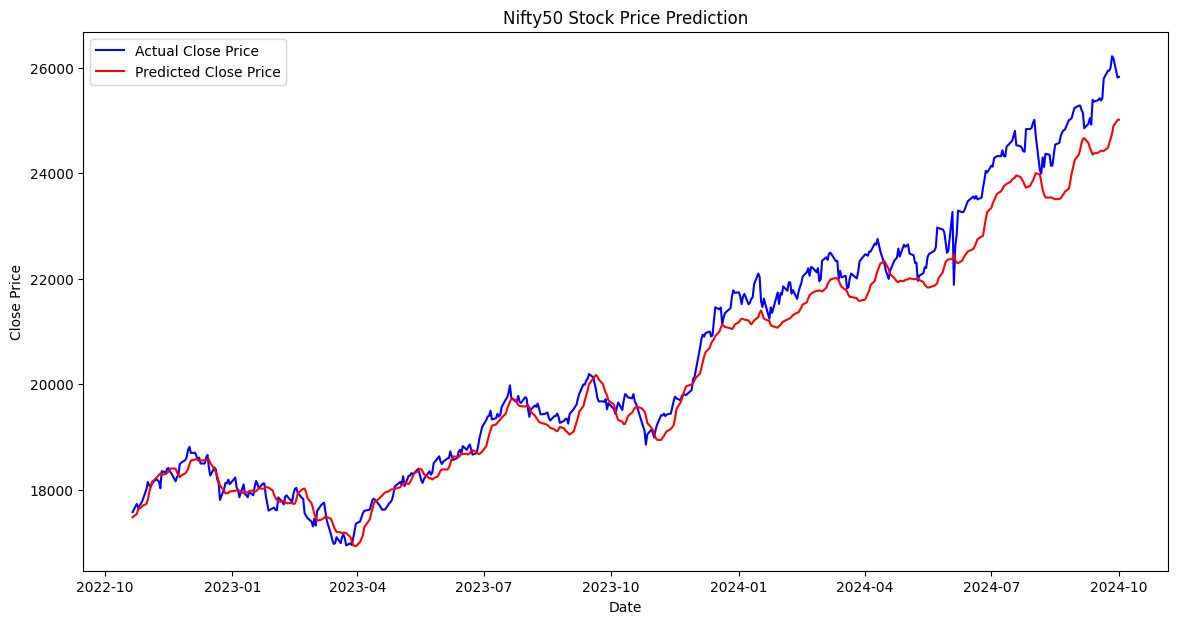

RMSE: 477.2050
MAE: 363.2899
MAPE:0.0166
Directional Accuracy: 50.63%


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Ensemble Prediction Function
def ensemble_predict(models, X):
    """
    Generate predictions from an ensemble of models by averaging.
    
    Parameters:
        models (list): List of trained LSTM models.
        X (ndarray): Input data for prediction.
        
    Returns:
        ndarray: Averaged predictions from the ensemble.
    """
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(torch.tensor(X, dtype=torch.float32).to(device)).cpu().numpy()
            predictions.append(pred)
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

# Make predictions on the test set
ensemble_pred = ensemble_predict(ensemble_models, X_test)

# Inverse transform the predictions and actual values
# Since we only scaled 'Close', we need to inverse transform accordingly
# Create an array with predictions and zeros for other features to inverse transform
ensemble_pred_inverse = scaler.inverse_transform(
    np.concatenate((ensemble_pred, np.zeros((ensemble_pred.shape[0], 3))), axis=1))[:,0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))), axis=1))[:,0]

# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(df['Date'][-len(y_test):], y_test_inverse, color='blue', label='Actual Close Price')
plt.plot(df['Date'][-len(y_test):], ensemble_pred_inverse, color='red', label='Predicted Close Price')
plt.title('Nifty50 Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, ensemble_pred_inverse))
mae = mean_absolute_error(y_test_inverse, ensemble_pred_inverse)
mape=mean_absolute_percentage_error(y_test_inverse, ensemble_pred_inverse)

# Directional Accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate the directional accuracy between true and predicted values.
    
    Parameters:
        y_true (ndarray): Actual values.
        y_pred (ndarray): Predicted values.
        
    Returns:
        float: Directional accuracy as a percentage.
    """
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    accuracy = np.sum(direction_true == direction_pred) / len(direction_true) * 100
    return accuracy

dir_acc = directional_accuracy(y_test_inverse, ensemble_pred_inverse)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE:{mape:.4f}")
print(f"Directional Accuracy: {dir_acc:.2f}%")


In [ ]:
#-------Uses newtonian inspired exploitation exploration balance----------

In [49]:
import random

class NewtonianParticle:
    def __init__(self, bounds):
        """
        Initialize a particle with random position and velocity.

        Parameters:
            bounds (list of tuples): Each tuple contains (min, max) for a hyperparameter.
        """
        self.position = []
        self.velocity = []
        for (min_val, max_val) in bounds:
            self.position.append(random.uniform(min_val, max_val))
            # Initialize velocity with a fraction of the range
            self.velocity.append(random.uniform(-0.1*(max_val - min_val), 0.1*(max_val - min_val)))
        self.best_position = list(self.position)
        self.best_score = float('inf')
        self.score = float('inf')

class NewtonianPSO:
    def __init__(self, func, bounds, num_particles, max_iter, w=0.5, c1=1, c2=2, c3=0.1):
        """
        Initialize the PSO algorithm with Newtonian-Inspired Exploration.

        Parameters:
            func (callable): The fitness function to minimize.
            bounds (list of tuples): Bounds for each dimension.
            num_particles (int): Number of particles in the swarm.
            max_iter (int): Maximum number of iterations.
            w (float): Inertia weight.
            c1 (float): Cognitive coefficient.
            c2 (float): Social coefficient.
            c3 (float): Exploration coefficient (Newtonian-Inspired).
        """
        self.func = func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3  # Coefficient for exploration term
        self.swarm = [Particle(bounds) for _ in range(num_particles)]
        self.global_best_position = []
        self.global_best_score = float('inf')

    def optimize(self):
        """
        Execute the PSO optimization process with Newtonian-Inspired Exploration.

        Returns:
            list: Best hyperparameters found.
            float: Best score achieved.
        """
        for iteration in range(self.max_iter):
            print(f"\n--- Iteration {iteration+1}/{self.max_iter} ---")
            for idx, particle in enumerate(self.swarm):
                # Evaluate fitness
                particle.score = self.func(particle.position)

                # Update personal best
                if particle.score < particle.best_score:
                    particle.best_score = particle.score
                    particle.best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New personal best score {particle.best_score:.6f}")

                # Update global best
                if particle.score < self.global_best_score:
                    self.global_best_score = particle.score
                    self.global_best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New global best score {self.global_best_score:.6f}")

            # Update velocity and position for each particle
            for particle in self.swarm:
                for i in range(len(particle.position)):
                    r1 = random.random()
                    r2 = random.random()
                    r3 = random.random()  # Random number for exploration

                    # Update velocity with PSO terms
                    cognitive = self.c1 * r1 * (particle.best_position[i] - particle.position[i])
                    social = self.c2 * r2 * (self.global_best_position[i] - particle.position[i])
                    exploration = self.c3 * r3 * (random.uniform(-1, 1))  # Newtonian-Inspired Exploration

                    # Incorporate exploration term into velocity
                    particle.velocity[i] = self.w * particle.velocity[i] + cognitive + social + exploration

                    # Update position
                    particle.position[i] += particle.velocity[i]

                    # Clamp to bounds
                    min_val, max_val = self.bounds[i]
                    if particle.position[i] < min_val:
                        particle.position[i] = min_val
                        particle.velocity[i] = 0  # Reset velocity if boundary is hit
                    elif particle.position[i] > max_val:
                        particle.position[i] = max_val
                        particle.velocity[i] = 0  # Reset velocity if boundary is hit

            print(f"End of Iteration {iteration+1}: Global Best Score = {self.global_best_score:.6f}")
        return self.global_best_position, self.global_best_score


In [48]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define hyperparameter bounds
bounds = [
    (1, 10),        # num_ensembles
    (0.0001, 0.01), # learning_rate
    (10, 200),      # lstm_units
    (0.0, 0.5),     # dropout_rate
    (16, 512),      # batch_size
    (10, 100)       # epochs
]

# Initialize PSO
newtonian_pso = NewtonianPSO(
    func=fitness_function,
    bounds=bounds,
    num_particles=5,  # Reduced for demonstration; increase for better optimization
    max_iter=3,       # Reduced for demonstration; increase for better optimization
    w=0.5,
    c1=1,
    c2=2
)

# Execute optimization
best_hyperparams_newt, best_score_newt = newtonian_pso.optimize()
print(f"Best Hyperparameters: {best_hyperparams_newt}")
print(f"Best Test Loss: {best_score_newt:.6f}")


Using device: cuda

--- Iteration 1/3 ---

Evaluating Hyperparameters: Ensembles=9, LR=0.0046184730993258025, Units=51, Dropout=0.4674152757344013, Batch Size=44, Epochs=42
  Training ensemble model 1/9
Epoch [1/42], Train Loss: 0.007152, Test Loss: 0.007064
Epoch [10/42], Train Loss: 0.000281, Test Loss: 0.012008
Epoch [20/42], Train Loss: 0.000500, Test Loss: 0.031379
Epoch [30/42], Train Loss: 0.000193, Test Loss: 0.024682
Epoch [40/42], Train Loss: 0.000167, Test Loss: 0.027220
    Model 1 Test Loss: 0.026714
  Training ensemble model 2/9
Epoch [1/42], Train Loss: 0.009551, Test Loss: 0.004051
Epoch [10/42], Train Loss: 0.000318, Test Loss: 0.018515
Epoch [20/42], Train Loss: 0.000232, Test Loss: 0.009079
Epoch [30/42], Train Loss: 0.000302, Test Loss: 0.018065
Epoch [40/42], Train Loss: 0.000201, Test Loss: 0.017951
    Model 2 Test Loss: 0.022973
  Training ensemble model 3/9
Epoch [1/42], Train Loss: 0.008126, Test Loss: 0.008790
Epoch [10/42], Train Loss: 0.000327, Test Loss: 0

In [50]:
def build_and_train_ensemble(best_hyperparams):
    """
    Build and train an ensemble of LSTM models based on the best hyperparameters.
    
    Parameters:
        best_hyperparams (list): Best hyperparameters [num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs].
        
    Returns:
        list: Trained LSTM models.
    """
    num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs = best_hyperparams
    
    #Ensure hyperparameters are within reasonable bounds
    num_ensembles = int(max(min(num_ensembles, 10), 1))  # 1 to 10
    learning_rate = max(min(learning_rate, 0.01), 0.0001)  # 0.0001 to 0.01
    lstm_units = int(max(min(lstm_units, 200), 10))  # 10 to 200
    dropout_rate = max(min(dropout_rate, 0.5), 0.0)  # 0.0 to 0.5
    batch_size = int(max(min(batch_size, 512), 16))  # 16 to 512
    epochs = int(max(min(epochs, 100), 10))  # 10 to 100
#     num_ensembles= int(num_ensembles)
#     learning_rate= int(learning_rate)
#     lstm_units = int(lstm_units)
#     dropout_rate = int(dropout_rate)
#     batch_size = int(batch_size)
#     epochs= int(epochs)
    print(f"{num_ensembles} {learning_rate} {lstm_units} {dropout_rate} {batch_size} {epochs}")

    
    models = []
    for i in range(num_ensembles):
        print(f"Training ensemble model {i+1}/{num_ensembles}")
        model = LSTMModel(input_size=4, hidden_size=lstm_units, num_layers=2, dropout=dropout_rate)
        model, train_losses, test_losses = train_model(
            model, 
            X_train_tensor, 
            y_train_tensor, 
            X_test_tensor, 
            y_test_tensor, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            device=device
        )
        models.append(model)
    return models

# Build and train the ensemble using the best hyperparameters
ensemble_models = build_and_train_ensemble(best_hyperparams_newt)


2 0.009206260043076689 123 0.0 279 10
Training ensemble model 1/2
Epoch [1/10], Train Loss: 0.048929, Test Loss: 0.180469
Epoch [10/10], Train Loss: 0.000327, Test Loss: 0.019522
Training ensemble model 2/2
Epoch [1/10], Train Loss: 0.055855, Test Loss: 0.148152
Epoch [10/10], Train Loss: 0.000168, Test Loss: 0.004124


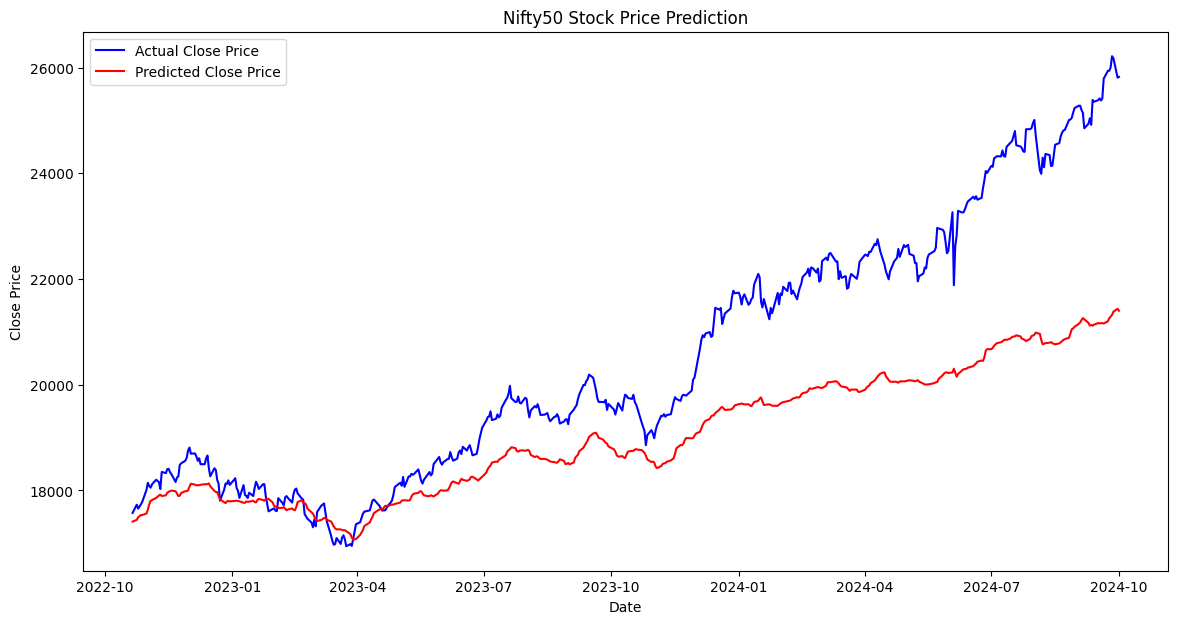

RMSE: 1959.7539
MAE: 1491.1059
MAPE: 0.0667
Directional Accuracy: 49.37%


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Ensemble Prediction Function
def ensemble_predict(models, X):
    """
    Generate predictions from an ensemble of models by averaging.
    
    Parameters:
        models (list): List of trained LSTM models.
        X (ndarray): Input data for prediction.
        
    Returns:
        ndarray: Averaged predictions from the ensemble.
    """
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(torch.tensor(X, dtype=torch.float32).to(device)).cpu().numpy()
            predictions.append(pred)
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

# Make predictions on the test set
ensemble_pred = ensemble_predict(ensemble_models, X_test)

# Inverse transform the predictions and actual values
# Since we only scaled 'Close', we need to inverse transform accordingly
# Create an array with predictions and zeros for other features to inverse transform
ensemble_pred_inverse = scaler.inverse_transform(
    np.concatenate((ensemble_pred, np.zeros((ensemble_pred.shape[0], 3))), axis=1))[:,0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))), axis=1))[:,0]

# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(df['Date'][-len(y_test):], y_test_inverse, color='blue', label='Actual Close Price')
plt.plot(df['Date'][-len(y_test):], ensemble_pred_inverse, color='red', label='Predicted Close Price')
plt.title('Nifty50 Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, ensemble_pred_inverse))
mae = mean_absolute_error(y_test_inverse, ensemble_pred_inverse)
mape= mean_absolute_percentage_error(y_test_inverse, ensemble_pred_inverse)

# Directional Accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate the directional accuracy between true and predicted values.
    
    Parameters:
        y_true (ndarray): Actual values.
        y_pred (ndarray): Predicted values.
        
    Returns:
        float: Directional accuracy as a percentage.
    """
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    accuracy = np.sum(direction_true == direction_pred) / len(direction_true) * 100
    return accuracy

dir_acc = directional_accuracy(y_test_inverse, ensemble_pred_inverse)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"Directional Accuracy: {dir_acc:.2f}%")

In [32]:
#---------------------PSO with Simulated annealing-----

In [33]:
import math

def simulated_annealing(current_solution, current_loss, temperature, bounds):
    """
    Perform a single iteration of Simulated Annealing.
    
    Parameters:
        current_solution (list): Current hyperparameters.
        current_loss (float): Current loss value.
        temperature (float): Current temperature.
        bounds (list of tuples): Bounds for each hyperparameter.
        
    Returns:
        new_solution (list): Potential new hyperparameters.
        new_loss (float): Loss value of the new solution.
    """
    # Generate a new candidate solution by perturbing current hyperparameters
    new_solution = current_solution.copy()
    # Perturb one hyperparameter at random
    idx = random.randint(0, len(new_solution)-1)
    perturbation = random.uniform(-0.1, 0.1) * (bounds[idx][1] - bounds[idx][0])
    new_solution[idx] += perturbation
    # Clamp to bounds
    new_solution[idx] = max(min(new_solution[idx], bounds[idx][1]), bounds[idx][0])
    
    # Evaluate the new solution
    new_loss = fitness_function(new_solution)
    
    # Decide whether to accept the new solution
    delta = new_loss - current_loss
    if delta < 0:
        return new_solution, new_loss
    else:
        acceptance_prob = math.exp(-delta / temperature)
        if random.random() < acceptance_prob:
            return new_solution, new_loss
        else:
            return current_solution, current_loss


In [34]:
class PSO_SA:
    def __init__(self, func, bounds, num_particles, max_iter, sa_cooldown=10, sa_initial_temp=1000, w=0.5, c1=1, c2=2):
        """
        Initialize the hybrid PSO + SA algorithm.
        
        Parameters:
            func (callable): The fitness function to minimize.
            bounds (list of tuples): Bounds for each hyperparameter.
            num_particles (int): Number of particles in the swarm.
            max_iter (int): Maximum number of iterations.
            sa_cooldown (int): Number of PSO iterations before applying SA.
            sa_initial_temp (float): Initial temperature for SA.
            w (float): Inertia weight.
            c1 (float): Cognitive coefficient.
            c2 (float): Social coefficient.
        """
        self.func = func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.sa_cooldown = sa_cooldown
        self.sa_initial_temp = sa_initial_temp
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.swarm = [Particle(bounds) for _ in range(num_particles)]
        self.global_best_position = []
        self.global_best_score = float('inf')
        
    def optimize(self):
        """
        Execute the PSO + SA optimization process.
        
        Returns:
            list: Best hyperparameters found.
            float: Best score achieved.
        """
        temperature = self.sa_initial_temp
        for iteration in range(self.max_iter):
            print(f"\n--- Iteration {iteration+1}/{self.max_iter} ---")
            for idx, particle in enumerate(self.swarm):
                # Evaluate fitness
                particle.score = self.func(particle.position)
    
                # Update personal best
                if particle.score < particle.best_score:
                    particle.best_score = particle.score
                    particle.best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New personal best score {particle.best_score:.6f}")
    
                # Update global best
                if particle.score < self.global_best_score:
                    self.global_best_score = particle.score
                    self.global_best_position = list(particle.position)
                    print(f"  Particle {idx+1}: New global best score {self.global_best_score:.6f}")
    
            # Apply Simulated Annealing periodically
            if (iteration + 1) % self.sa_cooldown == 0:
                print("  Applying Simulated Annealing for exploration.")
                for particle in self.swarm:
                    # Apply SA to individual particles
                    new_pos, new_loss = simulated_annealing(particle.position, particle.score, temperature, self.bounds)
                    if new_loss < particle.score:
                        particle.position = new_pos
                        particle.score = new_loss
                        if new_loss < particle.best_score:
                            particle.best_score = new_loss
                            particle.best_position = list(new_pos)
                            print(f"    Particle updated via SA to new personal best score {particle.best_score:.6f}")
                        if new_loss < self.global_best_score:
                            self.global_best_score = new_loss
                            self.global_best_position = list(new_pos)
                            print(f"    Particle updated via SA to new global best score {self.global_best_score:.6f}")
                # Cool down the temperature
                temperature *= 0.9  # Cooling schedule
    
            # Update velocity and position for each particle
            for particle in self.swarm:
                for i in range(len(particle.position)):
                    r1 = random.random()
                    r2 = random.random()
    
                    # Update velocity
                    cognitive = self.c1 * r1 * (particle.best_position[i] - particle.position[i])
                    social = self.c2 * r2 * (self.global_best_position[i] - particle.position[i])
                    particle.velocity[i] = self.w * particle.velocity[i] + cognitive + social
    
                    # Update position
                    particle.position[i] += particle.velocity[i]
    
                    # Clamp to bounds
                    min_val, max_val = self.bounds[i]
                    if particle.position[i] < min_val:
                        particle.position[i] = min_val
                    elif particle.position[i] > max_val:
                        particle.position[i] = max_val
    
            print(f"End of Iteration {iteration+1}: Global Best Score = {self.global_best_score:.6f}, Temperature = {temperature:.2f}")
        return self.global_best_position, self.global_best_score


In [38]:
# Initialize and run the hybrid PSO + SA
pso_sa = PSO_SA(
    func=fitness_function,
    bounds=bounds,
    num_particles=5,        # Adjust based on computational resources
    max_iter=3,            # Increased iterations for better optimization
    sa_cooldown=5,          # Apply SA every 5 iterations
    sa_initial_temp=1000,   # Initial temperature for SA
    w=0.5,
    c1=1,
    c2=2
)

# Execute optimization
best_hyperparams_psosa, best_score_psosa = pso_sa.optimize()
print(f"\nBest Hyperparameters: {best_hyperparams}")
print(f"Best Test Loss: {best_score:.6f}")



--- Iteration 1/3 ---

Evaluating Hyperparameters: Ensembles=9, LR=0.004086112659515191, Units=29, Dropout=0.0969188358618519, Batch Size=95, Epochs=21
  Training ensemble model 1/9
Epoch [1/21], Train Loss: 0.015133, Test Loss: 0.006806
Epoch [10/21], Train Loss: 0.000282, Test Loss: 0.008013
Epoch [20/21], Train Loss: 0.000208, Test Loss: 0.007798
    Model 1 Test Loss: 0.006671
  Training ensemble model 2/9
Epoch [1/21], Train Loss: 0.029073, Test Loss: 0.057324
Epoch [10/21], Train Loss: 0.000263, Test Loss: 0.011804
Epoch [20/21], Train Loss: 0.000197, Test Loss: 0.008496
    Model 2 Test Loss: 0.008811
  Training ensemble model 3/9
Epoch [1/21], Train Loss: 0.044201, Test Loss: 0.147648
Epoch [10/21], Train Loss: 0.000365, Test Loss: 0.009840
Epoch [20/21], Train Loss: 0.000269, Test Loss: 0.006009
    Model 3 Test Loss: 0.006385
  Training ensemble model 4/9
Epoch [1/21], Train Loss: 0.038909, Test Loss: 0.106384
Epoch [10/21], Train Loss: 0.000308, Test Loss: 0.012059
Epoch [2

In [39]:

def build_and_train_ensemble(best_hyperparams):
    """
    Build and train an ensemble of LSTM models based on the best hyperparameters.
    
    Parameters:
        best_hyperparams (list): Best hyperparameters [num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs].
        
    Returns:
        list: Trained LSTM models.
    """
    num_ensembles, learning_rate, lstm_units, dropout_rate, batch_size, epochs = best_hyperparams
    
    #Ensure hyperparameters are within reasonable bounds
    num_ensembles = int(max(min(num_ensembles, 10), 1))  # 1 to 10
    learning_rate = max(min(learning_rate, 0.01), 0.0001)  # 0.0001 to 0.01
    lstm_units = int(max(min(lstm_units, 200), 10))  # 10 to 200
    dropout_rate = max(min(dropout_rate, 0.5), 0.0)  # 0.0 to 0.5
    batch_size = int(max(min(batch_size, 512), 16))  # 16 to 512
    epochs = int(max(min(epochs, 100), 10))  # 10 to 100
#     num_ensembles= int(num_ensembles)
#     learning_rate= int(learning_rate)
#     lstm_units = int(lstm_units)
#     dropout_rate = int(dropout_rate)
#     batch_size = int(batch_size)
#     epochs= int(epochs)
    print(f"{num_ensembles} {learning_rate} {lstm_units} {dropout_rate} {batch_size} {epochs}")

    
    models = []
    for i in range(num_ensembles):
        print(f"Training ensemble model {i+1}/{num_ensembles}")
        model = LSTMModel(input_size=4, hidden_size=lstm_units, num_layers=2, dropout=dropout_rate)
        model, train_losses, test_losses = train_model(
            model, 
            X_train_tensor, 
            y_train_tensor, 
            X_test_tensor, 
            y_test_tensor, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            device=device
        )
        models.append(model)
    return models

# Build and train the ensemble using the best hyperparameters
ensemble_models = build_and_train_ensemble(best_hyperparams_psosa)


10 0.0001 200 0.02165674370865149 387 100
Training ensemble model 1/10
Epoch [1/100], Train Loss: 0.067733, Test Loss: 0.436473
Epoch [10/100], Train Loss: 0.018456, Test Loss: 0.140050
Epoch [20/100], Train Loss: 0.001817, Test Loss: 0.365198
Epoch [30/100], Train Loss: 0.000753, Test Loss: 0.032717
Epoch [40/100], Train Loss: 0.000471, Test Loss: 0.007469
Epoch [50/100], Train Loss: 0.000329, Test Loss: 0.001316
Epoch [60/100], Train Loss: 0.000272, Test Loss: 0.000281
Epoch [70/100], Train Loss: 0.000258, Test Loss: 0.000356
Epoch [80/100], Train Loss: 0.000254, Test Loss: 0.000428
Epoch [90/100], Train Loss: 0.000250, Test Loss: 0.000499
Epoch [100/100], Train Loss: 0.000250, Test Loss: 0.000473
Training ensemble model 2/10
Epoch [1/100], Train Loss: 0.064926, Test Loss: 0.434729
Epoch [10/100], Train Loss: 0.020092, Test Loss: 0.154732
Epoch [20/100], Train Loss: 0.001897, Test Loss: 0.449766
Epoch [30/100], Train Loss: 0.000712, Test Loss: 0.030604
Epoch [40/100], Train Loss: 0.0

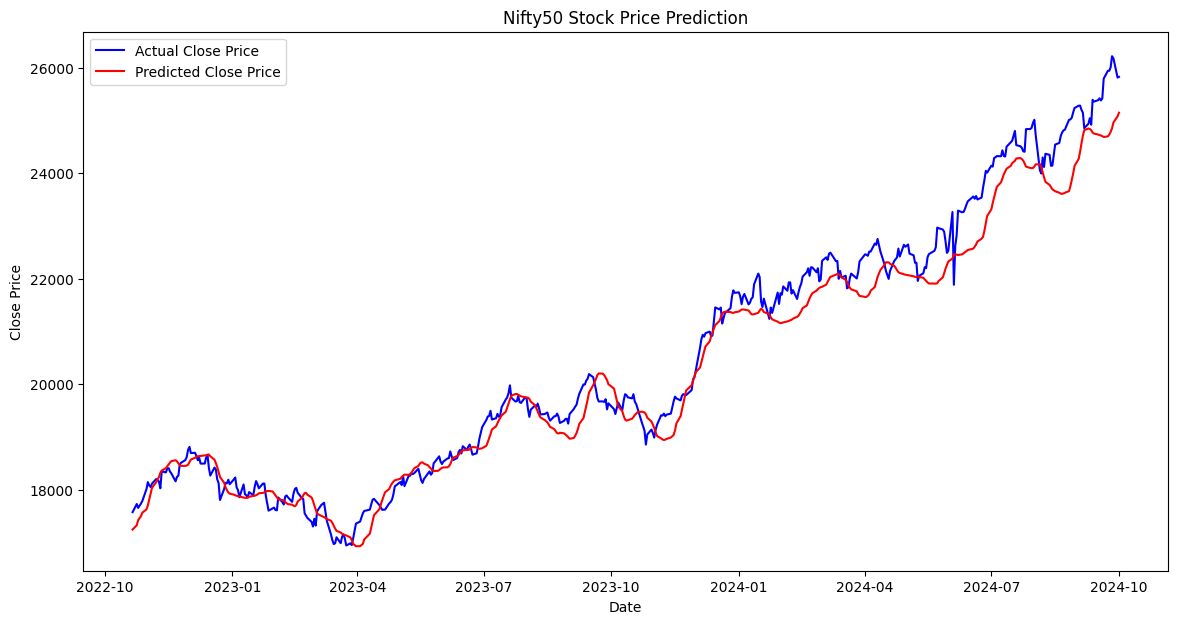

RMSE: 447.2194
MAE: 344.4509
MaAPE: 0.0161
Directional Accuracy: 50.00%


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Ensemble Prediction Function
def ensemble_predict(models, X):
    """
    Generate predictions from an ensemble of models by averaging.
    
    Parameters:
        models (list): List of trained LSTM models.
        X (ndarray): Input data for prediction.
        
    Returns:
        ndarray: Averaged predictions from the ensemble.
    """
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(torch.tensor(X, dtype=torch.float32).to(device)).cpu().numpy()
            predictions.append(pred)
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

# Make predictions on the test set
ensemble_pred = ensemble_predict(ensemble_models, X_test)

# Inverse transform the predictions and actual values
# Since we only scaled 'Close', we need to inverse transform accordingly
# Create an array with predictions and zeros for other features to inverse transform
ensemble_pred_inverse = scaler.inverse_transform(
    np.concatenate((ensemble_pred, np.zeros((ensemble_pred.shape[0], 3))), axis=1))[:,0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 3))), axis=1))[:,0]

# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(df['Date'][-len(y_test):], y_test_inverse, color='blue', label='Actual Close Price')
plt.plot(df['Date'][-len(y_test):], ensemble_pred_inverse, color='red', label='Predicted Close Price')
plt.title('Nifty50 Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, ensemble_pred_inverse))
mae = mean_absolute_error(y_test_inverse, ensemble_pred_inverse)
mape=mean_absolute_percentage_error(y_test_inverse, ensemble_pred_inverse)
# Directional Accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate the directional accuracy between true and predicted values.
    
    Parameters:
        y_true (ndarray): Actual values.
        y_pred (ndarray): Predicted values.
        
    Returns:
        float: Directional accuracy as a percentage.
    """
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    accuracy = np.sum(direction_true == direction_pred) / len(direction_true) * 100
    return accuracy

dir_acc = directional_accuracy(y_test_inverse, ensemble_pred_inverse)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"Directional Accuracy: {dir_acc:.2f}%")


In [54]:
#----------------------------------------------------------

In [5]:
print(X_train)

[[[0.05065871 0.04109218 0.04975297 0.5213446 ]
  [0.04581861 0.04109218 0.04975297 0.5213446 ]
  [0.04531461 0.04109218 0.04975297 0.5213446 ]
  ...
  [0.07403568 0.06191898 0.05335737 0.52338349]
  [0.07314977 0.06308713 0.05403578 0.55849971]
  [0.06010511 0.06256543 0.05431674 0.42021149]]

 [[0.04581861 0.04109218 0.04975297 0.5213446 ]
  [0.04531461 0.04109218 0.04975297 0.5213446 ]
  [0.05143812 0.04109218 0.04975297 0.5213446 ]
  ...
  [0.07314977 0.06308713 0.05403578 0.55849971]
  [0.06010511 0.06256543 0.05431674 0.42021149]
  [0.05879312 0.06138235 0.0545143  0.48275831]]

 [[0.04531461 0.04109218 0.04975297 0.5213446 ]
  [0.05143812 0.04109218 0.04975297 0.5213446 ]
  [0.04621093 0.04109218 0.04975297 0.5213446 ]
  ...
  [0.06010511 0.06256543 0.05431674 0.42021149]
  [0.05879312 0.06138235 0.0545143  0.48275831]
  [0.06567783 0.06120961 0.05478478 0.56475996]]

 ...

 [[0.49623413 0.48417676 0.49174318 0.74565312]
  [0.5006196  0.48669514 0.49264657 0.77601471]
  [0.50655